# Project 1: Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

%matplotlib inline

Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = UnityEnvironment(file_name = 'Banana.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

The next cell shows the performance of a random agent and the commands needed to interact with the Unity environment.

In [4]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score

t = time.time()
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

Score: 0.0


### 4. Solving the Environment

Next we implement various versions of the DQN agent to solve the environment.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

First, we import additional packages.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from collections import deque

In [5]:
%load_ext autoreload
%autoreload 2

The various DQN agents are included in the dqn.py file. We also included custom, weighted loss functions for use with the prioritized experience replay variant.

In [6]:
from dqn import DQNAgent, DoubleDQNAgent, PrioritizedDQNAgent, PrioritizedDoubleDQNAgent
from weighted_losses import weighted_mse_loss, weighted_smooth_l1_loss

Here, we define the architecture of the deep networks utilized by each agent. There are two model classes, one for the regular DQN agent and another that uses the dueling model architecture for the Dueling DQN agent (and any combinations of variants that include this feature).

The model classes below are for variable size deep neural networks to allow for easy hyperparameter tuning (e.g., number of layers, units in each layer, etc.). The regular model class allows for multiple relu activated hidden layers and a single regression output head. The dueling model is similar except that the output head - the regression for Q(s), the action-value function - is composed of the state-value, V(s), function and the advantage function, A(s), as described in the Dueling DQN paper referenced in the README section. This model also allows for a variable number of shared hidden layers and a variable number of hidden layers for the state-value and advantage-value functions. The used model architectures are included at instantiation of each agent below.

In [7]:
class Model(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        linear_layers = [nn.Linear(model_params['input_size'], 
                                   model_params['hidden_layers'][0])]
        for i, l in enumerate(model_params['hidden_layers']):
            if i == 0:
                continue
            linear_layers.append(nn.Linear(model_params['hidden_layers'][i - 1], 
                                           model_params['hidden_layers'][i]))
        
        self.linear_layers = nn.ModuleList(linear_layers)
        self.output_layer = nn.Linear(model_params['hidden_layers'][-1], 
                                      model_params['output_size'])

    def forward(self, x):
        # applying the relu activations in forward as they are stateless functions
        for i, l in enumerate(self.linear_layers):
            x = F.relu(l(x))
            
        x = self.output_layer(x)
        
        return x
    
def state_processor(state):
    return torch.tensor(state, dtype = torch.float32).unsqueeze(0)

In [8]:
class DuelingModel(nn.Module):
    def __init__(self, model_params):
        super().__init__()
        hidden_layers = [nn.Linear(model_params['input_size'], 
                                   model_params['hidden_layers'][0])]
        for i, l in enumerate(model_params['hidden_layers']):
            if i == 0:
                continue
            hidden_layers.append(nn.Linear(model_params['hidden_layers'][i - 1], 
                                           model_params['hidden_layers'][i]))
        self.hidden_layers = nn.ModuleList(hidden_layers)
        
        advantage_layers = [nn.Linear(model_params['hidden_layers'][i - 1], 
                                      model_params['advantage_hidden_layers'][0])]
        for i, l in enumerate(model_params['advantage_hidden_layers']):
            if i == 0:
                continue
            advantage_layers.append(nn.Linear(model_params['advantage_hidden_layers'][i - 1], 
                                              model_params['advantage_hidden_layers'][i]))
        self.advantage_layers = nn.ModuleList(advantage_layers)
        
        state_layers = [nn.Linear(model_params['hidden_layers'][i - 1], 
                                  model_params['state_hidden_layers'][0])]
        for i, l in enumerate(model_params['state_hidden_layers']):
            if i == 0:
                continue
            state_layers.append(nn.Linear(model_params['state_hidden_layers'][i - 1], 
                                          model_params['state_hidden_layers'][i]))
        self.state_layers = nn.ModuleList(state_layers)
        
        self.advantage_output = nn.Linear(model_params['advantage_hidden_layers'][-1], 
                                          model_params['output_size'])
        
        self.value_output = nn.Linear(model_params['state_hidden_layers'][-1], 1)

    def forward(self, x):
        # applying the relu activations in forward as they are stateless functions
        for i, l in enumerate(self.hidden_layers):
            x = F.relu(l(x))
        
        a = x
        for i, l in enumerate(self.advantage_layers):
            a = F.relu(l(a))
            
        s = x
        for i, l in enumerate(self.state_layers):
            s = F.relu(l(s))

        A_s = self.advantage_output(a)
        V_s = self.value_output(s)
        Q_s = V_s + (A_s - torch.mean(A_s))
        
        return Q_s

Next, we define our training function, which terminates once an agent has solved the environment (when the average score for the last 100 episodes was >= 13). For this project, each epsiode was allowed to continue until terminated by the environment - no limit on the number steps was imposed.

In [29]:
def train_dqn(agent, env, n_episodes = 2000, max_time = int(1e+9), verbose = 100, score_window = 100):
    scores = []
    score_window = deque(maxlen = score_window)
    average_scores = []
    score_std = []
    
    for i in range(n_episodes):
        total_reward = 0
        done = False
        
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0]
        action = agent.action(state, mode = 'train')

        for j in range(max_time):
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]
            
            total_reward += reward
            agent.add_to_replay_memory(state, action, reward, next_state, done)

            next_action = agent.action(next_state, mode = 'train')
            agent.update()

            if done:
                break

            state = next_state
            action = next_action

        agent.update_epsilon()
        try:
            agent.update_beta()
        except:
            pass
        
        scores.append(total_reward)
        score_window.append(total_reward)
        average_scores.append(np.mean(score_window))
        score_std.append(np.std(score_window))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i + 1, average_scores[-1]), end = '')
        sys.stdout.flush()
        if (i + 1) % verbose == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i + 1, average_scores[-1]))
            
        if average_scores[-1] >= 13.0:
            print('\nEnvironment solved in {} episodes!'.format(i + 1))
            break

    return scores, average_scores, score_std

Finally, we train the agents! After each agent is trained, we graph the score for each episode and the 100 episode running average score.

The hyperparameters for each agent are also outlined below. The model_params are the inputs to the pytorch model classes above. The other hyperparameters are provided directly to the model, such as gamma, epsilon, alpha and beta (for agents that use prioritized replay experience), the frequency at which to update the target network with the online network weights, etc.

In [30]:
print('DQN Agent')
model_params = {'input_size': 37,
                'hidden_layers': (128, 64, 32),
                'output_size': 4}

agent = DQNAgent(Model, model_params, state_processor, 4,
                 gamma = 0.99,
                 epsilon = 1.0,
                 min_epsilon = 1e-2,
                 epsilon_decay = .99,
                 loss_function = F.smooth_l1_loss, 
                 optimizer = optim.Adam,
                 learning_rate = 1e-3,
                 l2_regularization = 0.0,
                 batch_size = 64,
                 replay_memory = 10000,
                 replay_start = 500,
                 target_update_freq = 1000,
                 action_repeat = 1,
                 update_freq = 4)

t = time.time()
dqn_scores, dqn_average_scores, dqn_std = train_dqn(agent, env, n_episodes = 1000, 
                                                    max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

DQN Agent
Episode 100	Average Score: 2.08
Episode 200	Average Score: 7.22
Episode 300	Average Score: 12.08
Episode 400	Average Score: 12.24
Episode 457	Average Score: 13.02
Environment solved in 457 episodes!
Wall Time: 6.04111202955246


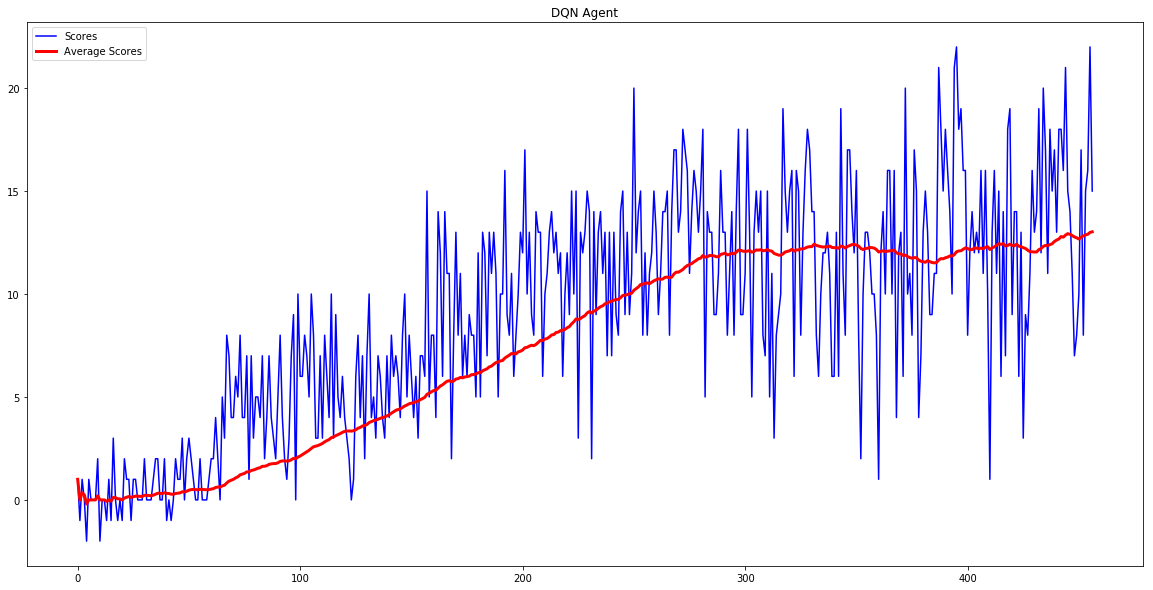

In [31]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(dqn_scores, '-b', label = 'Scores')
ax.plot(dqn_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('DQN Agent')
plt.show()

In [32]:
print('Double DQN Agent')
model_params = {'input_size': 37,
                'hidden_layers': (128, 64, 32),
                'output_size': 4}

agent = DoubleDQNAgent(Model, model_params, state_processor, 4,
                       gamma = 0.99,
                       epsilon = 1.0,
                       min_epsilon = 1e-2,
                       epsilon_decay = .99,
                       loss_function = F.smooth_l1_loss, 
                       optimizer = optim.Adam,
                       learning_rate = 1e-3,
                       l2_regularization = 0.0,
                       batch_size = 64,
                       replay_memory = 10000,
                       replay_start = 500,
                       target_update_freq = 1000,
                       action_repeat = 1,
                       update_freq = 4)

t = time.time()
double_dqn_scores, double_dqn_average_scores, double_dqn_std = train_dqn(agent, env, n_episodes = 1000, 
                                                                         max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

Double DQN Agent
Episode 100	Average Score: 2.27
Episode 200	Average Score: 7.66
Episode 300	Average Score: 11.62
Episode 363	Average Score: 13.02
Environment solved in 363 episodes!
Wall Time: 6.206493441263834


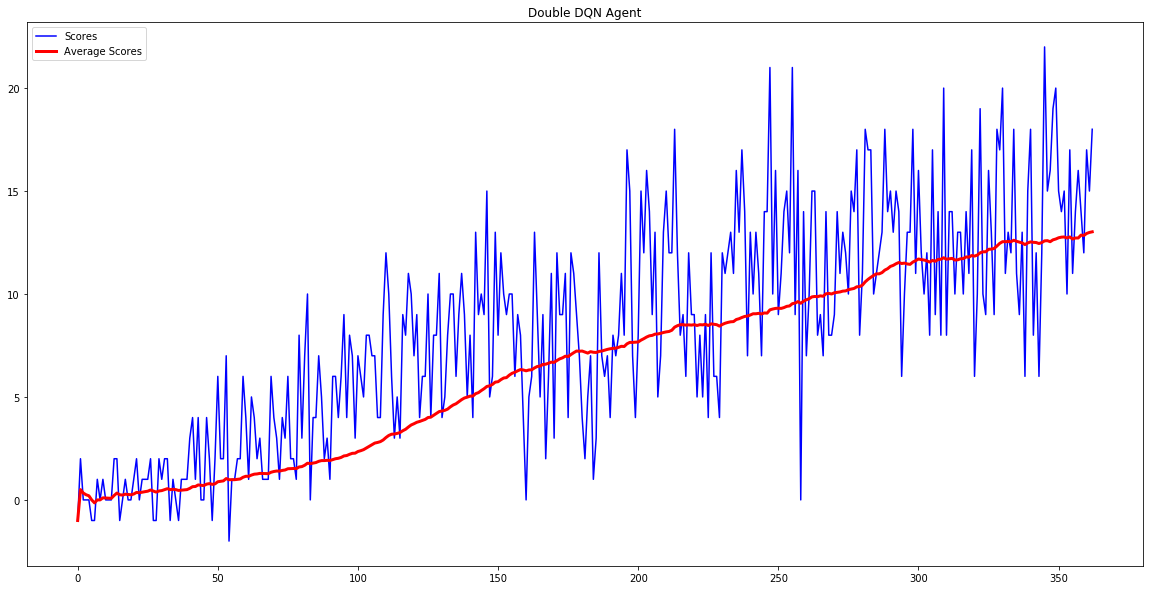

In [33]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(double_dqn_scores, '-b', label = 'Scores')
ax.plot(double_dqn_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('Double DQN Agent')
plt.show()

In [34]:
print('Dueling DQN Agent')
model_params = {'input_size': 37,
                'hidden_layers': (128, ),
                'state_hidden_layers': (48, ),
                'advantage_hidden_layers': (48, ),
                'output_size': 4}

agent = DQNAgent(DuelingModel, model_params, state_processor, 4,
                 gamma = 0.99,
                 epsilon = 1.0,
                 min_epsilon = 1e-2,
                 epsilon_decay = .99,
                 loss_function = F.smooth_l1_loss, 
                 optimizer = optim.Adam,
                 learning_rate = 1e-3,
                 l2_regularization = 0.0,
                 batch_size = 64,
                 replay_memory = 10000,
                 replay_start = 500,
                 target_update_freq = 1000,
                 action_repeat = 1,
                 update_freq = 4)

t = time.time()
dueling_dqn_scores, dueling_dqn_average_scores, dueling_dqn_std = train_dqn(agent, env, n_episodes = 1000, 
                                                                            max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

Dueling DQN Agent
Episode 100	Average Score: 1.65
Episode 200	Average Score: 7.01
Episode 300	Average Score: 12.02
Episode 400	Average Score: 12.37
Episode 414	Average Score: 13.03
Environment solved in 414 episodes!
Wall Time: 6.992899910608927


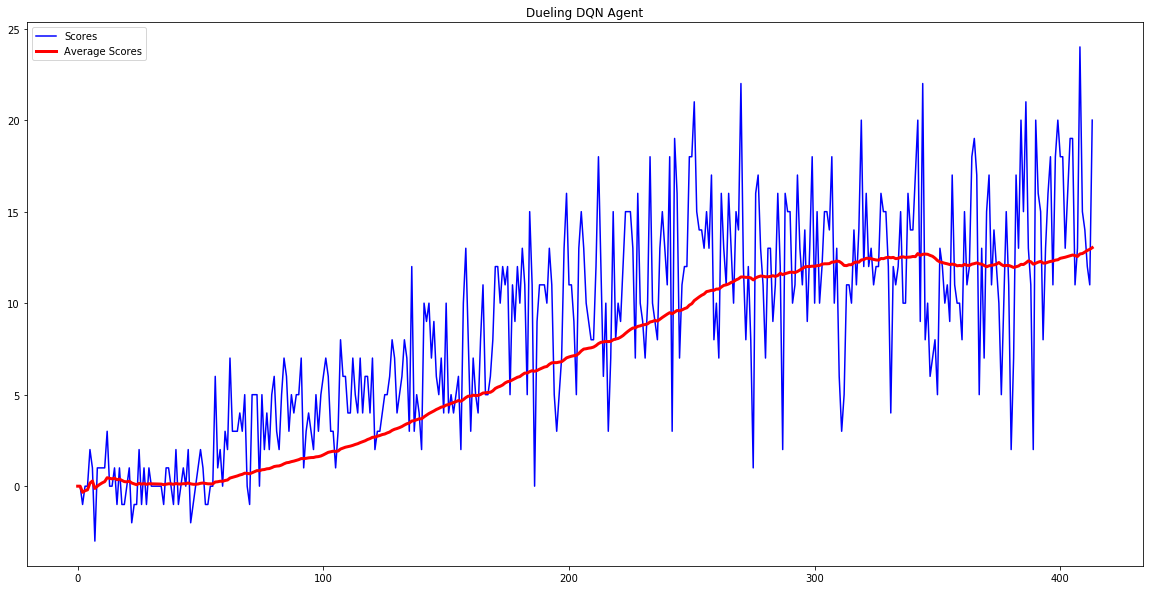

In [35]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(dueling_dqn_scores, '-b', label = 'Scores')
ax.plot(dueling_dqn_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('Dueling DQN Agent')
plt.show()

In [36]:
print('Prioritized DQN Agent')
model_params = {'input_size': 37,
                'hidden_layers': (128, 64, 32),
                'output_size': 4}

agent = PrioritizedDQNAgent(Model, model_params, state_processor, 4,
                            gamma = 0.99,
                            epsilon = 1.0,
                            min_epsilon = 1e-2,
                            epsilon_decay = .99,
                            loss_function = weighted_smooth_l1_loss, 
                            optimizer = optim.Adam,
                            learning_rate = 1e-3,
                            l2_regularization = 0.0,
                            batch_size = 64,
                            replay_memory = 10000,
                            replay_start = 500,
                            target_update_freq = 1000,
                            action_repeat = 1,
                            update_freq = 4,
                            alpha = 0.6,
                            beta = 0.4, 
                            beta_annealing_episodes = 300)

t = time.time()
per_dqn_scores, per_dqn_average_scores, per_dqn_std = train_dqn(agent, env, n_episodes = 1000, 
                                                                max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

Episode 100	Average Score: 2.17
Episode 200	Average Score: 8.62
Episode 300	Average Score: 12.44
Episode 365	Average Score: 13.10
Environment solved in 365 episodes!
Wall Time: 7.437175913651784


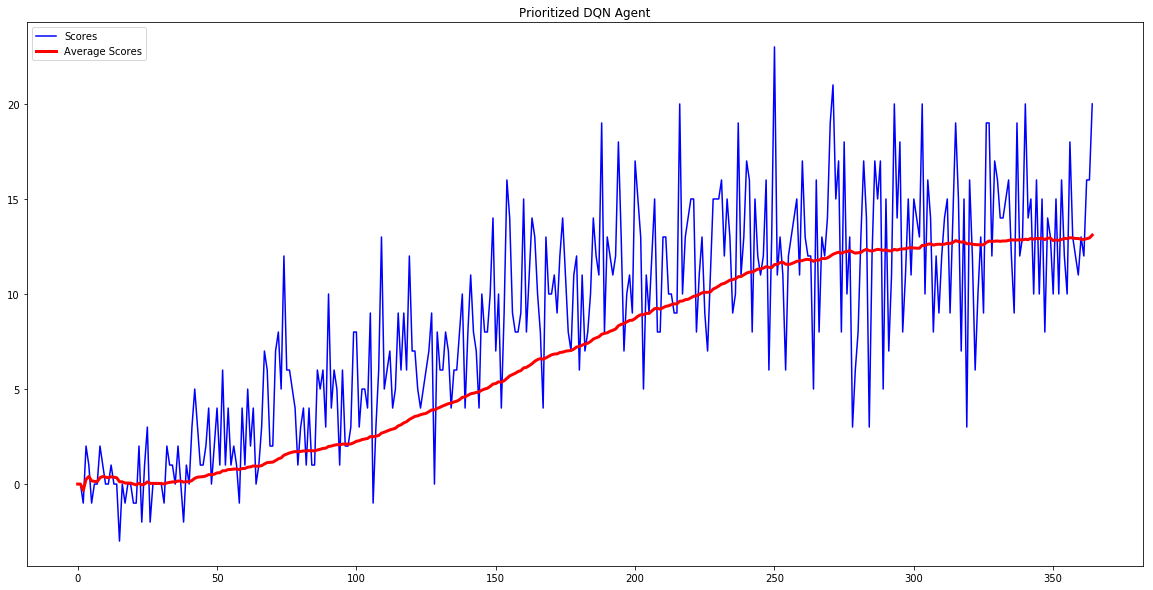

In [37]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(per_dqn_scores, '-b', label = 'Scores')
ax.plot(per_dqn_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('Prioritized DQN Agent')
plt.show()

In [38]:
print('Double Dueling DQN Agent')
model_params = {'input_size': 37,
                'hidden_layers': (128, ),
                'state_hidden_layers': (48, ),
                'advantage_hidden_layers': (48, ),
                'output_size': 4}

agent = DoubleDQNAgent(DuelingModel, model_params, state_processor, 4,
                       gamma = 0.99,
                       epsilon = 1.0,
                       min_epsilon = 1e-2,
                       epsilon_decay = .99,
                       loss_function = F.smooth_l1_loss, 
                       optimizer = optim.Adam,
                       learning_rate = 1e-3,
                       l2_regularization = 0.0,
                       batch_size = 64,
                       replay_memory = 10000,
                       replay_start = 500,
                       target_update_freq = 1000,
                       action_repeat = 1,
                       update_freq = 4)

t = time.time()
dd_dqn_scores, dd_dqn_average_scores, dd_dqn_std = train_dqn(agent, env, n_episodes = 1000, 
                                                             max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

Double Dueling DQN Agent
Episode 100	Average Score: 2.26
Episode 200	Average Score: 8.40
Episode 300	Average Score: 11.35
Episode 400	Average Score: 13.03

Environment solved in 400 episodes!
Wall Time: 7.098084314664205


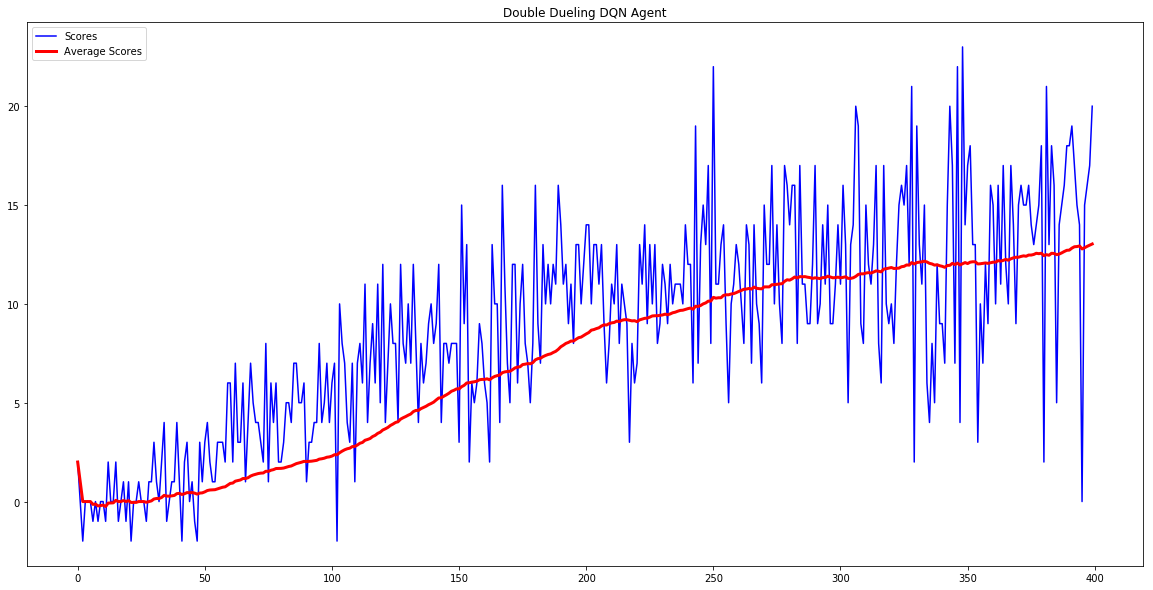

In [39]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(dd_dqn_scores, '-b', label = 'Scores')
ax.plot(dd_dqn_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('Double Dueling DQN Agent')
plt.show()

In [54]:
print('Rainbow DQN')
model_params = {'input_size': 37,
                'hidden_layers': (128, ),
                'state_hidden_layers': (48, ),
                'advantage_hidden_layers': (48, ),
                'output_size': 4}

agent = PrioritizedDoubleDQNAgent(DuelingModel, model_params, state_processor, 4,
                                  gamma = 0.99,
                                  epsilon = 1.0,
                                  min_epsilon = 1e-2,
                                  epsilon_decay = .99,
                                  loss_function = weighted_smooth_l1_loss, 
                                  optimizer = optim.Adam,
                                  learning_rate = 1e-3,
                                  l2_regularization = 0.0,
                                  batch_size = 64,
                                  replay_memory = 10000,
                                  replay_start = 500,
                                  target_update_freq = 1000,
                                  action_repeat = 1,
                                  update_freq = 4,
                                  alpha = 0.6,
                                  beta = 0.4, 
                                  beta_annealing_episodes = 300)

t = time.time()
rainbow_scores, rainbow_average_scores, rainbow_std = train_dqn(agent, env, n_episodes = 1000, 
                                                                max_time = int(1e+9), verbose = 100)
print('Wall Time:', (time.time() - t) / 60)

Rainbow DQN
Episode 100	Average Score: 0.92
Episode 200	Average Score: 7.91
Episode 300	Average Score: 11.63
Episode 354	Average Score: 13.01
Environment solved in 354 episodes!
Wall Time: 6.680738178888957


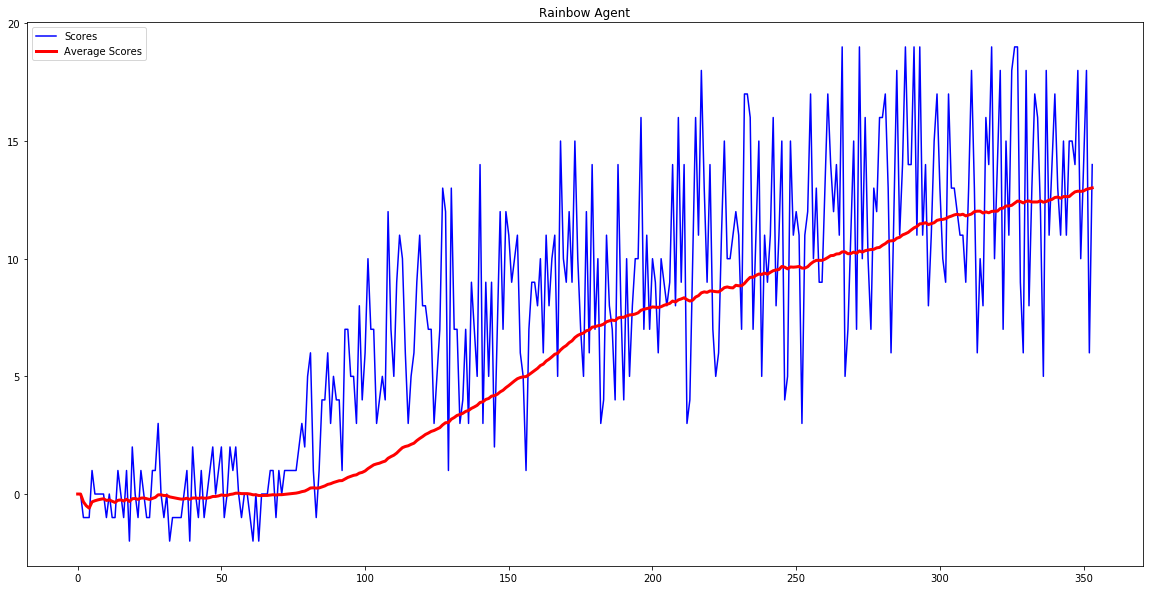

In [55]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(rainbow_scores, '-b', label = 'Scores')
ax.plot(rainbow_average_scores, '-r', label = 'Average Scores', linewidth = 3)
ax.legend(loc = 'upper left')
ax.set_title('Rainbow Agent')
plt.show()

The rainbow agent was the best performer. However, when tuning the hyperparameters of the model, there was significant variation in the number of episodes required to solve the environment. We do not include the average or median results of the agents over multiple runs here; however, that would provide a better baseline to compare performance across the different models.

The graph below shows the 100 episode running average score for each agent durnig training. The agents all performed quite similarly, and each additional feature (e.g., double DQN, prioritized experience replay, etc.) improved performance over the vanilla DQN.

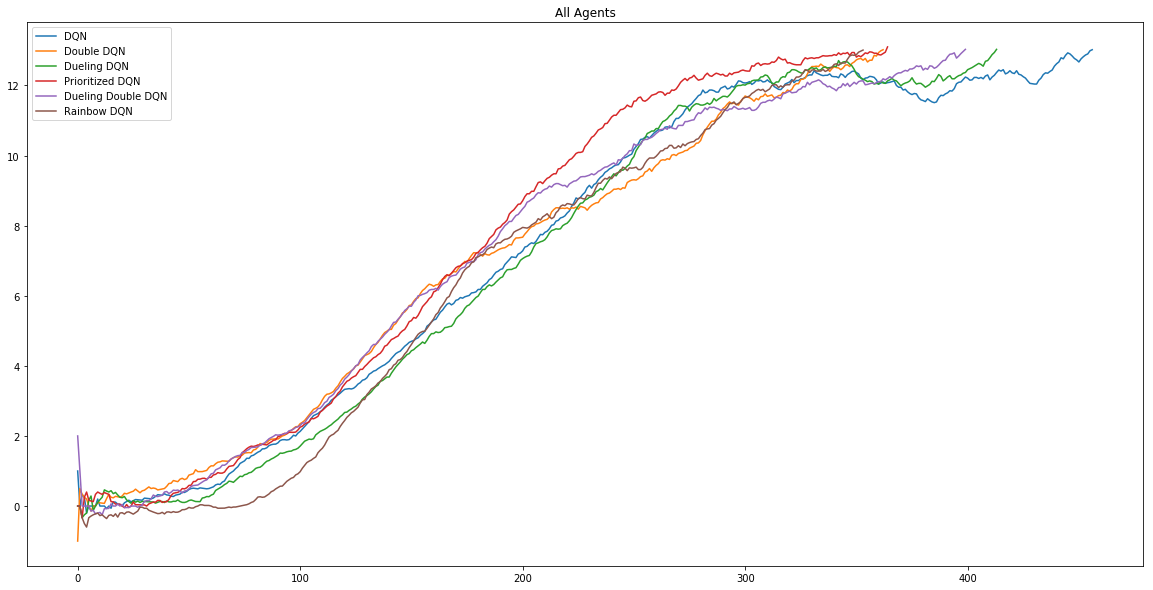

In [58]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(dqn_average_scores, label = 'DQN')
ax.plot(double_dqn_average_scores, label = 'Double DQN')
ax.plot(dueling_dqn_average_scores, label = 'Dueling DQN')
ax.plot(per_dqn_average_scores, label = 'Prioritized DQN')
ax.plot(dd_dqn_average_scores, label = 'Dueling Double DQN')
ax.plot(rainbow_average_scores, label = 'Rainbow DQN')
ax.legend(loc = 'upper left')
ax.set_title('All Agents')
plt.show()

Lastly, we save the weights and biases of the rainbow_agent, which in this case was the fastest learner, solving the environment in only 354 episodes, and close the environment.

In [57]:
torch.save(agent.online_network.state_dict(), 'rainbow_agent.pt')
env.close()

### 5. Ideas for Future Work

While multiple variations of DQN were included in this project, there are still other variations that could be tried on their own or in combination with a larger rainbow version, including Noisy DQN and Distributional DQN. 

Additionally, policy gradient methods may be successful in this environment as they avoid the use of the epsilon-greedy policy, which can easily lead to the accumulation of a large number of purple bananas, and thus a lower score, from random actions that disrupt what otherwise may be a successful navigation around/through areas of purple bananas. Similarly, actor-critic methods, which learn approximations to both a value function and parameterized polciy, could yield similar improvements.